## Sprocket Customer Segmentation Project

### Context

Sprocket Central Pty Ltd , a medium size bikes & cycling accessories organisation, has approached Tony Smith (Partner) in our consulting company's Lighthouse & Innovation Team. Sprocket Central Pty Ltd  is keen to learn more about the company's expertise in its Analytics, Information & Modelling team. 

Smith discusses our expertise in this space. In particular, he speaks about how the team can effectively analyse the datasets to help Sprocket Central Pty Ltd grow its business.

Primarily, Sprocket Central Pty Ltd needs help with its customer and transactions data. The organisation has a large dataset relating to its customers, but their team is unsure how to effectively analyse it to help optimise its marketing strategy. 

### Task

Using the existing 3 datasets (Customer demographic, customer address and transactions) as a labelled dataset, please recommend which of Sprockets new customers in the 'new customer list' dataset should be targeted to drive the most value for the organisation. 

### Plan

1. Split Sprockets existing customer base into various segments that can be individually targeted using techniques such as K-Means Clustering and Recency, Frequency and Monetary segmentation


2. Develop a supervised learning model to predict which segments Sprockets new customers would fall under.

In [321]:
# linear algebra
import numpy as np 

# data processing
import pandas as pd 

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

# date and time
import datetime as dt

#Algorithms
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier

In [191]:
#Read transaction data 
pd.set_option('display.max_rows', None)
transac = pd.read_excel('Sprocket.xlsx', sheet_name=1,skiprows=0)
transac.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,2017-02-25,False,Approved,Solex,Standard,Medium,Medium,71.49,53.62,2012-12-02
1,2,3,3120,2017-05-21,True,Approved,Trek Bicycles,Standard,Medium,Large,2091.47,388.92,2014-03-03
2,3,37,402,2017-10-16,False,Approved,OHM Cycles,Standard,Low,Medium,1793.43,248.82,1999-07-20
3,4,88,3135,2017-08-31,False,Approved,Norco Bicycles,Standard,Medium,Medium,1198.46,381.10,1998-12-16
4,5,78,787,2017-10-01,True,Approved,Giant Bicycles,Standard,Medium,Large,1765.30,709.48,2015-08-10


In [192]:
# Read Customer Demographic data
pd.set_option('display.max_rows', None)
cust_dem = pd.read_excel('Sprocket.xlsx', sheet_name=3,skiprows=0)
cust_dem.head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure
0,1,Laraine,Medendorp,Female,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,Yes,11.0
1,2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,Yes,16.0
2,3,Arlin,Dearle,Male,61,1954-01-20,Recruiting Manager,Property,Mass Customer,N,Yes,15.0
3,4,Talbot,NaN,Male,33,1961-10-03,NaN,IT,Mass Customer,N,No,7.0
4,5,Sheila-kathryn,Calton,Female,56,1977-05-13,Senior Editor,NaN,Affluent Customer,N,Yes,8.0


In [193]:
# Read Customer Addres data
pd.set_option('display.max_rows', None)
cust_add = pd.read_excel('Sprocket.xlsx', sheet_name=4,skiprows=0)
cust_add.head()

,customer_id,address,postcode,state,country,property_valuation
0,1,060 Morning Avenue,2016,NSW,Australia,10
1,2,6 Meadow Vale Court,2153,NSW,Australia,10
2,4,0 Holy Cross Court,4211,QLD,Australia,9
3,5,17979 Del Mar Point,2448,NSW,Australia,4
4,6,9 Oakridge Court,3216,VIC,Australia,9


In [194]:
# Merge transaction and customer demographic DataFrames on customer_id
merged = pd.merge(transac, cust_dem, on='customer_id')
merged.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,...,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure
0,1,2,2950,2017-02-25,False,Approved,Solex,Standard,Medium,Medium,...,Anthony,Male,19,1955-01-11,Software Engineer I,Financial Services,Mass Customer,N,Yes,10.0
1,11065,1,2950,2017-10-16,False,Approved,Giant Bicycles,Standard,Medium,Medium,...,Anthony,Male,19,1955-01-11,Software Engineer I,Financial Services,Mass Customer,N,Yes,10.0
2,18923,62,2950,2017-04-26,False,Approved,Solex,Standard,Medium,Medium,...,Anthony,Male,19,1955-01-11,Software Engineer I,Financial Services,Mass Customer,N,Yes,10.0
3,2,3,3120,2017-05-21,True,Approved,Trek Bicycles,Standard,Medium,Large,...,O'Donnell,Female,89,1979-02-04,Clinical Specialist,Health,Mass Customer,N,Yes,10.0
4,6862,4,3120,2017-10-05,False,Approved,Giant Bicycles,Standard,High,Medium,...,O'Donnell,Female,89,1979-02-04,Clinical Specialist,Health,Mass Customer,N,Yes,10.0


In [195]:
# Merge transaction and customer demographic and customer address DataFrames on customer_id
cust_tran = pd.merge(merged, cust_add, on='customer_id')
cust_tran.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,...,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,address,postcode,state,country,property_valuation
0,1,2,2950,2017-02-25,False,Approved,Solex,Standard,Medium,Medium,...,Financial Services,Mass Customer,N,Yes,10.0,984 Hoepker Court,3064,VIC,Australia,6
1,11065,1,2950,2017-10-16,False,Approved,Giant Bicycles,Standard,Medium,Medium,...,Financial Services,Mass Customer,N,Yes,10.0,984 Hoepker Court,3064,VIC,Australia,6
2,18923,62,2950,2017-04-26,False,Approved,Solex,Standard,Medium,Medium,...,Financial Services,Mass Customer,N,Yes,10.0,984 Hoepker Court,3064,VIC,Australia,6
3,2,3,3120,2017-05-21,True,Approved,Trek Bicycles,Standard,Medium,Large,...,Health,Mass Customer,N,Yes,10.0,4 Shopko Circle,2196,NSW,Australia,5
4,6862,4,3120,2017-10-05,False,Approved,Giant Bicycles,Standard,High,Medium,...,Health,Mass Customer,N,Yes,10.0,4 Shopko Circle,2196,NSW,Australia,5


In [196]:
# Select required features
sprocket = pd.DataFrame(data=cust_tran,columns=['transaction_id','product_id','customer_id','transaction_date',
                                                'list_price', 'standard_cost','product_first_sold_date', 
                                                'past_3_years_bike_related_purchases', 'DOB'])

In [197]:
# View first 5 rows of new Sprocket DataFrame
sprocket.head()

,transaction_id,product_id,customer_id,transaction_date,list_price,standard_cost,product_first_sold_date,past_3_years_bike_related_purchases,DOB
0,1,2,2950,2017-02-25,71.49,53.62,2012-12-02,19,1955-01-11
1,11065,1,2950,2017-10-16,1403.50,954.82,2003-02-07,19,1955-01-11
2,18923,62,2950,2017-04-26,478.16,298.72,2010-11-05,19,1955-01-11
3,2,3,3120,2017-05-21,2091.47,388.92,2014-03-03,89,1979-02-04
4,6862,4,3120,2017-10-05,1129.13,677.48,2011-04-16,89,1979-02-04


In [198]:
#Drop rows with missing values as they make up less than 3% of the data 
sprocket.dropna(inplace=True)

#Reset index
sprocket = sprocket.reset_index(drop=True)

In [199]:
#Display statistics for numerical features
sprocket.describe()

,transaction_id,product_id,customer_id,list_price,standard_cost,past_3_years_bike_related_purchases
count,19335.000000,19335.000000,19335.000000,19335.000000,19335.000000,19335.000000
mean,9988.570934,45.790070,1740.081303,1106.615601,555.896088,48.941298
std,5773.791341,30.561015,1010.130658,582.886996,405.814845,28.639388
min,1.000000,0.000000,1.000000,12.010000,7.210000,0.000000
25%,4993.500000,18.000000,859.000000,575.270000,215.140000,24.000000
50%,9983.000000,45.000000,1737.000000,1163.890000,507.580000,48.000000
75%,14986.500000,72.000000,2615.000000,1635.300000,795.100000,73.000000
max,20000.000000,100.000000,3500.000000,2091.470000,1759.850000,99.000000


### Summary of data review

1. Outliers: From the statistics information, we can deduce that there are no outliers in our data with our numerical variable datapoints falling within a range of 0 and 3 Z-Score.

2. Transaction Date: We would need to feature engineer year and month features from our transaction date feature

3. DOB: An Age feature will be created from our DOB feature

4. Profit: A profit feature will be created by subtracting standard_cost from list_price 

5. Recency, Frequency & Monetary: Create new features to hold values for recency, frequency and monetary for each customer


## Data Analysis, pre-processing & Feature engineering

### Create New Features

In [200]:
# Construct Year, Month and YearMonth from Transaction Date field
sprocket['year'], sprocket['month'] = sprocket['transaction_date'].dt.year, sprocket['transaction_date'].dt.month
sprocket['yearmonth'] = sprocket['transaction_date'].map(lambda x: 100*x.year + x.month)

In [201]:
# Construct Age from DOB field

def from_dob_to_age(born):
    today = dt.date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

sprocket['age']= sprocket['DOB'].apply(lambda x: from_dob_to_age(x))

In [202]:
# Construct Profit from standard_cost from list_price fields
sprocket['profit'] = sprocket['list_price'] - sprocket['standard_cost'] 

In [203]:
# Create "Date" column in datetime format to use for index
sprocket['date'] = pd.to_datetime(sprocket.transaction_date.dt.date)
sprocket.set_index('date', inplace=True)
sprocket.sort_values(by='date',inplace=True)

### EDA on New Features

In [204]:
sprocket.head()

,transaction_id,product_id,customer_id,transaction_date,list_price,standard_cost,product_first_sold_date,past_3_years_bike_related_purchases,DOB,year,month,yearmonth,age,profit
date,,,,,,,,,,,,,,
2017-01-01,12782,71,1762,2017-01-01,1842.92,1105.75,2011-01-10,49,1978-04-30,2017,1,201701,42,737.17
2017-01-01,11996,59,1349,2017-01-01,1061.56,733.58,1993-07-20,83,1997-05-07,2017,1,201701,23,327.98
2017-01-01,15138,3,1022,2017-01-01,2091.47,388.92,1999-07-26,56,1990-03-04,2017,1,201701,30,1702.55
2017-01-01,16920,18,113,2017-01-01,575.27,431.45,2013-03-12,67,1956-05-06,2017,1,201701,64,143.82
2017-01-01,2008,38,722,2017-01-01,1577.53,826.51,2001-11-25,69,1956-03-17,2017,1,201701,64,751.02


In [205]:
sprocket.describe()

,transaction_id,product_id,customer_id,list_price,standard_cost,past_3_years_bike_related_purchases,year,month,yearmonth,age,profit
count,19335.000000,19335.000000,19335.000000,19335.000000,19335.000000,19335.000000,19335.0,19335.000000,19335.000000,19335.000000,19335.000000
mean,9988.570934,45.790070,1740.081303,1106.615601,555.896088,48.941298,2017.0,6.517766,201706.517766,42.706077,550.719512
std,5773.791341,30.561015,1010.130658,582.886996,405.814845,28.639388,0.0,3.449001,3.449001,12.890016,492.986790
min,1.000000,0.000000,1.000000,12.010000,7.210000,0.000000,2017.0,1.000000,201701.000000,18.000000,4.800000
25%,4993.500000,18.000000,859.000000,575.270000,215.140000,24.000000,2017.0,4.000000,201704.000000,33.000000,133.780000
50%,9983.000000,45.000000,1737.000000,1163.890000,507.580000,48.000000,2017.0,7.000000,201707.000000,43.000000,445.210000
75%,14986.500000,72.000000,2615.000000,1635.300000,795.100000,73.000000,2017.0,10.000000,201710.000000,52.000000,827.160000
max,20000.000000,100.000000,3500.000000,2091.470000,1759.850000,99.000000,2017.0,12.000000,201712.000000,176.000000,1702.550000


### Summary of Data Review

In [206]:
#Drop Outlier Values
sprocket = sprocket[sprocket['age'] != 176] 
sprocket = sprocket[sprocket['age'] != 88] 
sprocket = sprocket[sprocket['age'] != 85] 

### Analysis of Sprocket KPIs by Month

In [207]:
# 1. Profit - Generate Monthly KPIs DataFrame by aggregating profit
m_kpis = pd.DataFrame(sprocket.groupby('month')['profit'].sum())

# 2. Generate Monthly Growth rate based on previous months profit
m_kpis['Growth'] = m_kpis['profit'].pct_change()

# 3. Generate Active Customers
m_kpis['Active Customers'] = pd.DataFrame(sprocket.groupby('month')['customer_id'].nunique())

# 4. Generate Monthly Order Count 
m_kpis['Order Count'] = pd.DataFrame(sprocket.groupby('month')['transaction_id'].count())

# 5. Generate Monthly Average Profit
m_kpis['Average Profit'] =  pd.DataFrame(sprocket.groupby('month')['profit'].mean())

In [208]:
m_kpis 

,profit,Growth,Active Customers,Order Count,Average Profit
month,,,,,
1,902892.21,NaN,1307,1618,558.029796
2,854247.67,-0.053876,1260,1584,539.297771
3,852525.23,-0.002016,1270,1586,537.531671
4,875446.09,0.026886,1267,1593,549.558123
5,897494.57,0.025185,1273,1637,548.255693
6,833923.60,-0.070832,1224,1522,547.913009
7,910387.59,0.091692,1306,1650,551.750055
8,939474.66,0.031950,1328,1690,555.902166
9,840842.01,-0.104987,1221,1517,554.279506


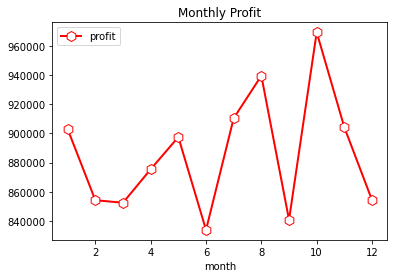

In [209]:
# Line Graph to capture the monthly profit
m_kpis.plot.line(y='profit', title='Monthly Profit',color = 'r',
         marker='h', 
         markersize=10, linewidth=2,
         markerfacecolor='white');

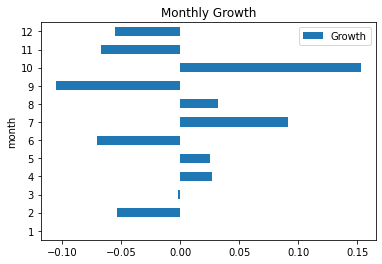

In [210]:
# Horizontal Bar Graph to capture monthly profit growth rate
m_kpis.plot.barh(y='Growth',title='Monthly Growth', rot=0);

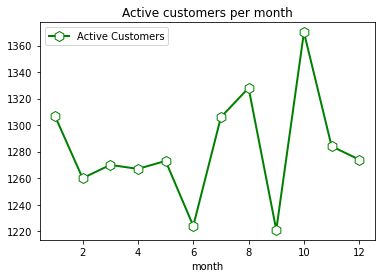

In [211]:
# Line graph to capture the active customers per month
m_kpis.plot.line(y='Active Customers', title='Active customers per month',color = 'g',
         marker='h', 
         markersize=10, linewidth=2,
         markerfacecolor='white');

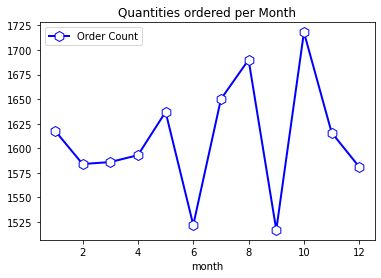

In [212]:
# Line graph to capture order count per month
m_kpis.plot.line(y='Order Count',title='Quantities ordered per Month',color = 'b',
         marker='h', 
         markersize=10, linewidth=2,
         markerfacecolor='white');

### RFM Segmentation (Recency, Frequency & Monetary)

#### RFM stands for Recency - Frequency - Monetary Value with the following definitions:

1. Recency - How much time has elapsed since a customers last activity or transaction
2. Frequency - How often a customer transacted with the company within a period of time
3. Monetary Value/Revenue - How much revenue a customer has generated within a period of time

This segmentation technique allows us target specific clusters of customers with product or communication 
that are much more relevant for their particular behaviour.

#### Approach
The approach we will follow will be:

1. Recency- Calculate the number of days between present date and date of last purchase for each customer
2. Frequency- Equate to past_3_years_bike_related_purchases
3. Monetary- Calculate the total profit from each customer

### Recency Score

In [213]:
# Generate new dataframe based on unique Customer_id to keep track of RFM scores
customer = pd.DataFrame(sprocket['customer_id'].unique())
customer.columns = ['customer_id']

In [214]:
# Generate new data frame based on latest transaction date from sprocket dataframe per Customer (groupby = Customer_id)
recency = sprocket.groupby('customer_id').transaction_date.max().reset_index()
recency.columns = ['customer_id','LastPurchaseDate']

# Set observation point as the last transaction date in the dataset
LastTransactionDate = recency['LastPurchaseDate'].max()

#Set assumed present date
present = dt.datetime(2018,1,1)

# Generate Recency in days by subtracting the Last Purchase date for each customer from assumed present date
recency['recency'] = (present - recency['LastPurchaseDate']).dt.days

In [215]:
# Consolidate to customer DataFrame
customer = pd.merge(customer, recency[['customer_id','recency']], on='customer_id')
customer.head()

,customer_id,recency
0,1762,23
1,1349,45
2,1022,85
3,113,177
4,722,89


In [216]:
# Review statistics around Recency score 
customer.describe()

,customer_id,recency
count,3410.000000,3410.000000
mean,1751.650440,63.606158
std,1009.314111,58.511647
min,1.000000,2.000000
25%,878.250000,20.000000
50%,1751.500000,46.000000
75%,2623.750000,88.000000
max,3500.000000,355.000000


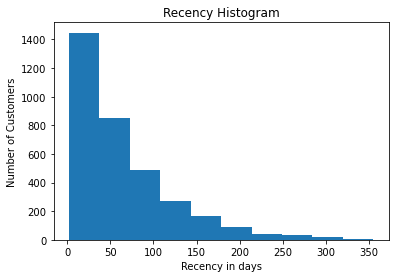

In [217]:
# Plot Recency
customer.recency.plot.hist();
plt.xlabel("Recency in days")
plt.ylabel("Number of Customers")
plt.title("Recency Histogram");

### Frequency Score

In [218]:
# Create using past_3_years_bike_related_purchases and store in new frequency Dataframe
freq = pd.DataFrame(data=sprocket[['customer_id','past_3_years_bike_related_purchases']]).reset_index()
frequ = freq.drop(['date'],axis=1)

In [219]:
frequency = pd.DataFrame(frequ['customer_id'].unique())
frequency.columns = ['customer_id']
frequency.insert(1, 'frequency',frequ['past_3_years_bike_related_purchases'])

In [220]:
frequency.head()

,customer_id,frequency
0,1762,49
1,1349,83
2,1022,56
3,113,67
4,722,69


In [221]:
# Consolidate Frequency to existing Customer DataFrame
customer = pd.merge(customer, frequency, on='customer_id')
customer.head()

,customer_id,recency,frequency
0,1762,23,49
1,1349,45,83
2,1022,85,56
3,113,177,67
4,722,89,69


In [222]:
# Review statistics around Recency score 
customer.describe()

,customer_id,recency,frequency
count,3410.000000,3410.000000,3410.000000
mean,1751.650440,63.606158,48.818182
std,1009.314111,58.511647,28.440420
min,1.000000,2.000000,0.000000
25%,878.250000,20.000000,24.000000
50%,1751.500000,46.000000,48.000000
75%,2623.750000,88.000000,73.000000
max,3500.000000,355.000000,99.000000


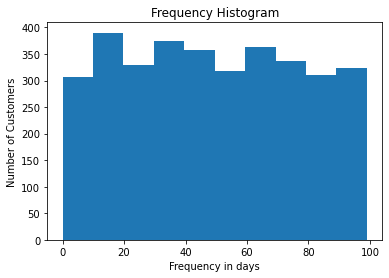

In [223]:
# Plot Frequency
customer.frequency.sort_values().head(3412).plot.hist();
plt.xlabel("Frequency in days")
plt.ylabel("Number of Customers")
plt.title("Frequency Histogram");

### Monetary Score

In [224]:
# Profit per transaction has already been calculated as per KPIs section
# Grouping profit per Customer ID
monetary = sprocket.groupby('customer_id').profit.sum().reset_index()
monetary.columns = ['customer_id','monetary']

In [225]:
# Consolidate Revenue to existing Customer DataFrame
customer = pd.merge(customer, monetary, on='customer_id')
customer.head()

,customer_id,recency,frequency,monetary
0,1762,23,49,5870.93
1,1349,45,83,1905.16
2,1022,85,56,6444.49
3,113,177,67,2329.49
4,722,89,69,2934.44


In [226]:
customer.describe()

,customer_id,recency,frequency,monetary
count,3410.000000,3410.000000,3410.000000,3410.000000
mean,1751.650440,63.606158,48.818182,3118.732768
std,1009.314111,58.511647,28.440420,1769.591072
min,1.000000,2.000000,0.000000,15.080000
25%,878.250000,20.000000,24.000000,1834.317500
50%,1751.500000,46.000000,48.000000,2847.585000
75%,2623.750000,88.000000,73.000000,4163.900000
max,3500.000000,355.000000,99.000000,11668.950000


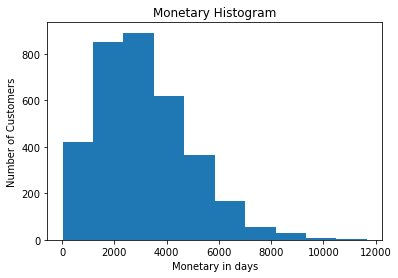

In [227]:
# Plot Monetary
customer.monetary.sort_values().head(3412).plot.hist();
plt.xlabel("Monetary in days")
plt.ylabel("Number of Customers")
plt.title("Monetary Histogram");

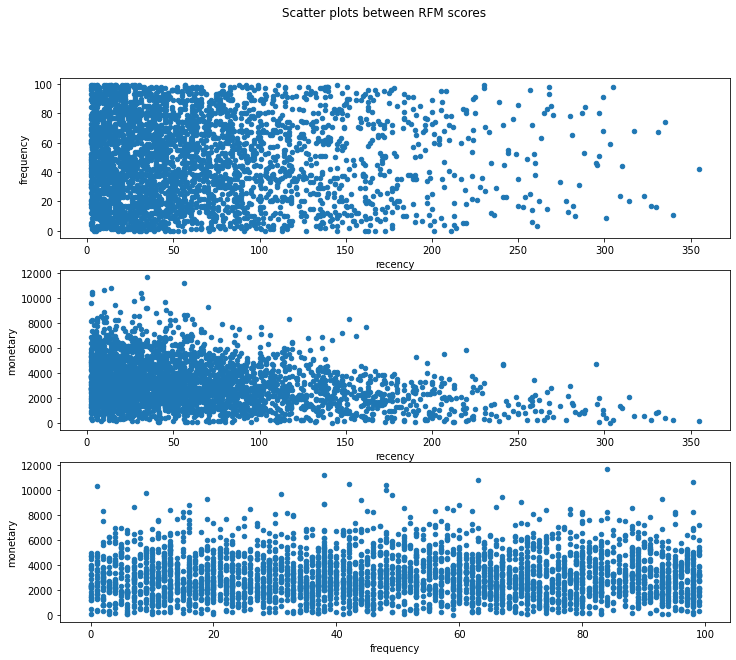

In [228]:
# Finally lets review the scatter plots among the different scores

fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.suptitle('Scatter plots between RFM scores')
customer.plot.scatter(x = 'recency', y = 'frequency', ax = ax1, figsize = (12,10));
customer.plot.scatter(x = 'recency', y = 'monetary', ax = ax2);
customer.plot.scatter(x = 'frequency', y = 'monetary', ax = ax3);

In [229]:
# Consolidate Customer to existing Sprocket DataFrame
sproc = pd.merge(customer, sprocket, on='customer_id')
sproc.head()

,customer_id,recency,frequency,monetary,transaction_id,product_id,transaction_date,list_price,standard_cost,product_first_sold_date,past_3_years_bike_related_purchases,DOB,year,month,yearmonth,age,profit
0,1762,23,49,5870.93,12782,71,2017-01-01,1842.92,1105.75,2011-01-10,49,1978-04-30,2017,1,201701,42,737.17
1,1762,23,49,5870.93,5138,14,2017-01-11,1386.84,1234.29,2013-03-12,49,1978-04-30,2017,1,201701,42,152.55
2,1762,23,49,5870.93,12361,31,2017-01-29,230.91,173.18,1995-12-19,49,1978-04-30,2017,1,201701,42,57.73
3,1762,23,49,5870.93,4852,13,2017-01-29,1163.89,589.27,2010-05-05,49,1978-04-30,2017,1,201701,42,574.62
4,1762,23,49,5870.93,14257,29,2017-04-04,543.39,407.54,1991-11-10,49,1978-04-30,2017,4,201704,42,135.85


### Determining RFM Quartiles

#### Tiered Groups
The customers will be divided into tiered groups for each of the three dimensions(RFM)
Customers with the lowest recency, highest frequency and monetary values are considered as top customers. 

qcut() is a Quantile-based function that will be used to categorize the RFM scores. 
The way it works is that it bins the data based on sample quantiles. 

In [230]:
quantiles = sproc.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [231]:
# Function to create RFM values
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [232]:
#Split into bins
sproc['r_quartile'] = sproc['recency'].apply(RScore, args=('recency',quantiles,))
sproc['f_quartile'] = sproc['frequency'].apply(FMScore, args=('frequency',quantiles,))
sproc['m_quartile'] = sproc['monetary'].apply(FMScore, args=('monetary',quantiles,))

In [233]:
#Concatenate RFM quartiles into one column
sproc['RFMClass'] = sproc.r_quartile.map(str) + sproc.f_quartile.map(str) + sproc.m_quartile.map(str)

#Calculate RFM_Score
sproc['RFM_Score']= sproc[['r_quartile','f_quartile','m_quartile']].sum(axis=1)
sproc.head()

,customer_id,recency,frequency,monetary,transaction_id,product_id,transaction_date,list_price,standard_cost,product_first_sold_date,...,year,month,yearmonth,age,profit,r_quartile,f_quartile,m_quartile,RFMClass,RFM_Score
0,1762,23,49,5870.93,12782,71,2017-01-01,1842.92,1105.75,2011-01-10,...,2017,1,201701,42,737.17,2,3,1,231,6
1,1762,23,49,5870.93,5138,14,2017-01-11,1386.84,1234.29,2013-03-12,...,2017,1,201701,42,152.55,2,3,1,231,6
2,1762,23,49,5870.93,12361,31,2017-01-29,230.91,173.18,1995-12-19,...,2017,1,201701,42,57.73,2,3,1,231,6
3,1762,23,49,5870.93,4852,13,2017-01-29,1163.89,589.27,2010-05-05,...,2017,1,201701,42,574.62,2,3,1,231,6
4,1762,23,49,5870.93,14257,29,2017-04-04,543.39,407.54,1991-11-10,...,2017,4,201704,42,135.85,2,3,1,231,6


### Modelling

In [234]:
# Creating input features variable
model = sproc[['recency', 'frequency', 'monetary']]
model.head()

,recency,frequency,monetary
0,23,49,5870.93
1,23,49,5870.93
2,23,49,5870.93
3,23,49,5870.93
4,23,49,5870.93


### Data Distribution.

In [235]:
# Helper function to plot variable distribution
def graph_histo(x):
    if x.dtype == "int64" or x.dtype == "float64":
        # Select size of bins by getting maximum and minimum and divide the substraction by 10
        size_bins = 10
        # Get the title by getting the name of the column
        title = x.name
        #Assign random colors to each graph
        color_kde = list(map(float, np.random.rand(3,)))
        color_bar = list(map(float, np.random.rand(3,)))

        # Plot the displot
        sns.distplot(x, bins=size_bins, kde_kws={"lw": 1.5, "alpha":0.8, "color":color_kde},
                       hist_kws={"linewidth": 1.5, "edgecolor": "grey",
                                "alpha": 0.4, "color":color_bar})
        # Customize ticks and labels
        plt.xticks(size=14)
        plt.yticks(size=14);
        plt.ylabel("Frequency", size=16, labelpad=15);
        # Customize title
        plt.title(title, size=18)
        # Customize grid and axes visibility
        plt.grid(False);
        plt.gca().spines["top"].set_visible(False);
        plt.gca().spines["right"].set_visible(False);
        plt.gca().spines["bottom"].set_visible(False);
        plt.gca().spines["left"].set_visible(False);   
    else:
        x = pd.DataFrame(x)
        # Plot       
        sns.catplot(x=x.columns[0], kind="count", palette="spring", data=x)
        # Customize title
        title = x.columns[0]
        plt.title(title, size=18)
        # Customize ticks and labels
        plt.xticks(size=14)
        plt.yticks(size=14);
        plt.xlabel("")
        plt.ylabel("Counts", size=16, labelpad=15);        
        # Customize grid and axes visibility
        plt.gca().spines["top"].set_visible(False);
        plt.gca().spines["right"].set_visible(False);
        plt.gca().spines["bottom"].set_visible(False);
        plt.gca().spines["left"].set_visible(False);

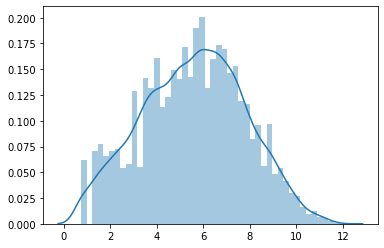

In [236]:
#Box-Cox Transformation to correct skewness of data
var_rec = model['recency']
ndist_rec, rec_lmda = stats.boxcox(var_rec)
sns.distplot(ndist_rec)

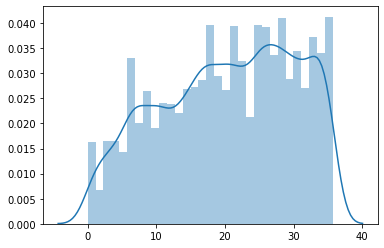

In [237]:
#Box-Cox Transformation to correct skewness of data
var_freq = model[model['frequency'] > 0]['frequency']
ndist_freq, freq_lmda = stats.boxcox(var_freq)
sns.distplot(ndist_freq)

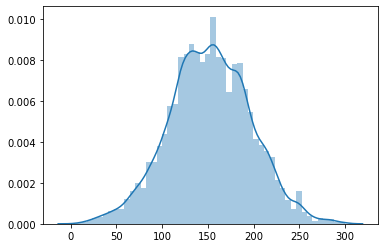

In [238]:
#Box-Cox Transformation to correct skewness of data
var_mon = model['monetary']
ndist_mon, mon_lmda = stats.boxcox(var_mon)
sns.distplot(ndist_mon)

### Scale Features

In [239]:
#Define StandardScaler
scaler = StandardScaler()

#Transform Variable
scaled_data = scaler.fit_transform(model)
X = pd.DataFrame(scaler.fit_transform(model), columns=model.columns)
X.head()

,recency,frequency,monetary
0,-0.633472,-0.010991,1.216344
1,-0.633472,-0.010991,1.216344
2,-0.633472,-0.010991,1.216344
3,-0.633472,-0.010991,1.216344
4,-0.633472,-0.010991,1.216344


### Descriptive Statistics

In [240]:
# Helper function to display Mean, Standard Deviation, Median, Variance of numerical features and value_counts for categorical features
def statistics(variable):
    if variable.dtype == "int64" or variable.dtype == "float64":
        return pd.DataFrame([[variable.name, np.mean(variable), np.std(variable), np.median(variable), np.var(variable)]], 
                            columns = ["Variable", "Mean", "Standard Deviation", "Median", "Variance"]).set_index("Variable")
    else:
        return pd.DataFrame(variable.value_counts())

In [241]:
# Display stats
var_rec = X['recency']
statistics(var_rec)

,Mean,Standard Deviation,Median,Variance
Variable,,,,
recency,1.499824e-16,1.0,-0.292145,1.0


In [242]:
# Display stats
var_freq = X['frequency']
statistics(var_freq)

,Mean,Standard Deviation,Median,Variance
Variable,,,,
frequency,6.477259e-17,1.0,-0.010991,1.0


In [243]:
# Display stats
var_mon = X['monetary']
statistics(var_mon)

,Mean,Standard Deviation,Median,Variance
Variable,,,,
monetary,-1.602637e-15,1.0,-0.117212,1.0


### Heatmap to check correlation of features 

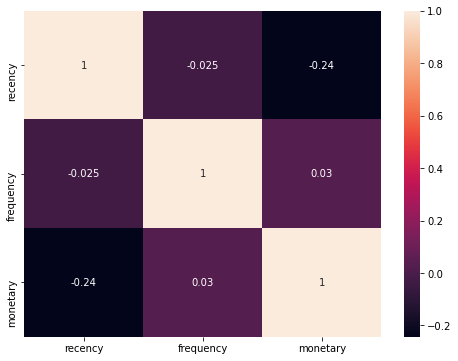

In [244]:
#How correlated are the features?
plt.figure(figsize=(8,6))
sns.heatmap(X.corr(),annot=True)

#### Why is looking into these parameters important?

When working with K-Means Clustering Algorithm, some assumptions are made. 
#### K-Means assumes:
    1. The variance of the distribution is spherical meaning that clusters have a spherical shape. 
    In order for this to be true, all variables would need to be normally distributed and have the same variances.
    
    2. There is little or no correlation between variables
    

### Dimensionality Reduction using Principal Component Analysis (PCA)

#### Why PCA?
PCA has the ability to process our independent set of variables in such a manner where we end up with the set of variables which has more insightful information and very little noise. With less noise and reduced dimensions, the data set becomes extremely lightweight, can be visualized better. It can also be much more easily processed by our ML models with very little overfitting. 

Text(0, 0.5, 'Cumulative Explained Variance')

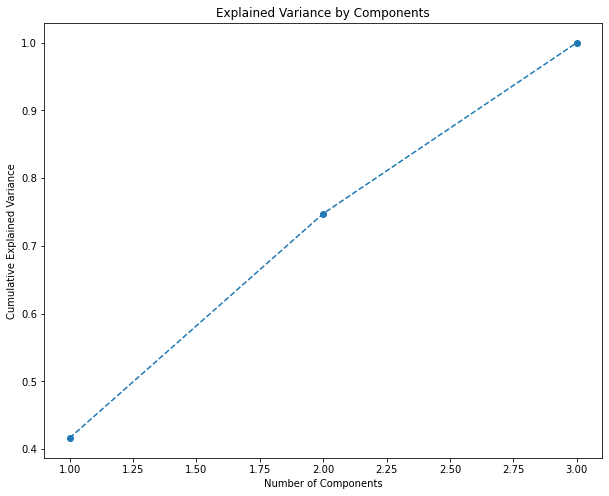

In [245]:
#Instantiate PCA Model
pca = PCA()
#Fit Model
pca.fit(X)

#The attribute shows how much variance each of the three individual components has.
pca.explained_variance_ratio_

plt.figure(figsize = (10,8))
plt.plot(range(1,4),pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

In [246]:
#The graph shows the amount of variance captured (y-axis) depending on the number of components we include(x-axis). 
# We will preserve around 80% of the variance. So in this instance, we will keep 2 components

In [247]:
#Select 2 components for the pca model
pca = PCA(n_components=2)

#Fit the model with selected components
pca.fit(X)

#Transform model
pca.transform(X)

array([[-1.29136452, -0.20516765],
       [-1.29136452, -0.20516765],
       [-1.29136452, -0.20516765],
       ...,
       [ 0.51436052, -0.02994594],
       [ 0.51436052, -0.02994594],
       [ 0.29531069,  0.90136614]])

In [248]:
# Save PCA transformation scores in a variable
scores_pca = pca.transform(X)

### K-Means Clustering

#### Elbow Method to find the optimal value for K

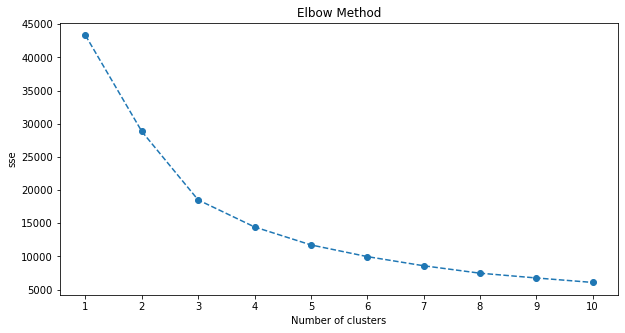

In [249]:
# This involves running several k-means and incrementing k with each iteration, and recording the SSE.
kmeans_kwargs = {"init": "k-means++","n_init": 10,"max_iter": 300,"random_state": 42}

# Create list to hold the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scores_pca)
    sse.append(kmeans.inertia_)
    
plt.figure(figsize=(10,5))
plt.plot(range(1,11),sse, marker = 'o', linestyle= '--')
plt.xticks(range(1, 11))
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('sse')
plt.show()

In [250]:
#Instantiate Model with 3 clusters
kmeans = KMeans(init="k-means++",n_clusters=3,n_init=50,max_iter=500,random_state=42)

In [251]:
#Fit Model
kmeans.fit(scores_pca)

KMeans(max_iter=500, n_clusters=3, n_init=50, random_state=42)

#### K-Means Clustering Results

In [252]:
# Review output cluster labels
cluster_labels = kmeans.predict(scores_pca)

In [253]:
#Review inertia score
kmeans.inertia_

18509.118626613483

In [254]:
# Review silhouette score
#ss = silhouette_score(scores_pca, cluster_labels, metric='euclidean')
#ss

In [255]:
# Optimal Number of Clusters
#It looks like 3 is the optimal number of clusters looking at both the silhoutte score and inertia. 

In [256]:
# Review Centroids of clusters
centroids = kmeans.cluster_centers_
centroids

array([[-0.62111254,  0.81443957],
       [ 1.4992917 ,  0.24532945],
       [-0.23316813, -0.94104394]])

In [257]:
#Lets add in our result back to our existing customer demographic DataFrame.
X_kmeans = pd.concat([cust_dem,pd.DataFrame(scores_pca)], axis = 1)
X_kmeans.columns.values[-2: ] = ['component 1', 'component 2']

#Add K-Means Clustering Labels
X_kmeans['clusters'] = cluster_labels
X_kmeans.head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,component 1,component 2,clusters
0,1.0,Laraine,Medendorp,Female,93.0,1953-10-12,Executive Secretary,Health,Mass Customer,N,Yes,11.0,-1.291365,-0.205168,0
1,2.0,Eli,Bockman,Male,81.0,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,Yes,16.0,-1.291365,-0.205168,0
2,3.0,Arlin,Dearle,Male,61.0,1954-01-20,Recruiting Manager,Property,Mass Customer,N,Yes,15.0,-1.291365,-0.205168,0
3,4.0,Talbot,NaN,Male,33.0,1961-10-03,NaN,IT,Mass Customer,N,No,7.0,-1.291365,-0.205168,0
4,5.0,Sheila-kathryn,Calton,Female,56.0,1977-05-13,Senior Editor,NaN,Affluent Customer,N,Yes,8.0,-1.291365,-0.205168,0


In [258]:
# Generate new dataframe based on Customer_id to keep track of RFM scores
rfm = pd.DataFrame(sproc['customer_id'])
rfm.columns = ['customer_id'] 

In [259]:
# Consolidate to rfm DataFrame
rfm = pd.merge(rfm, sproc[['customer_id','RFM_Score']], on='customer_id')
rfm.head()

,customer_id,RFM_Score
0,1762,6
1,1762,6
2,1762,6
3,1762,6
4,1762,6


In [260]:
# Consolidate to X_kmeans DataFrame
X_kmeans = pd.merge(X_kmeans, rfm[['customer_id','RFM_Score']], on='customer_id')
X_kmeans.head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,component 1,component 2,clusters,RFM_Score
0,1.0,Laraine,Medendorp,Female,93.0,1953-10-12,Executive Secretary,Health,Mass Customer,N,Yes,11.0,-1.291365,-0.205168,0,7
1,1.0,Laraine,Medendorp,Female,93.0,1953-10-12,Executive Secretary,Health,Mass Customer,N,Yes,11.0,-1.291365,-0.205168,0,7
2,1.0,Laraine,Medendorp,Female,93.0,1953-10-12,Executive Secretary,Health,Mass Customer,N,Yes,11.0,-1.291365,-0.205168,0,7
3,1.0,Laraine,Medendorp,Female,93.0,1953-10-12,Executive Secretary,Health,Mass Customer,N,Yes,11.0,-1.291365,-0.205168,0,7
4,1.0,Laraine,Medendorp,Female,93.0,1953-10-12,Executive Secretary,Health,Mass Customer,N,Yes,11.0,-1.291365,-0.205168,0,7


### Visualize Clusters

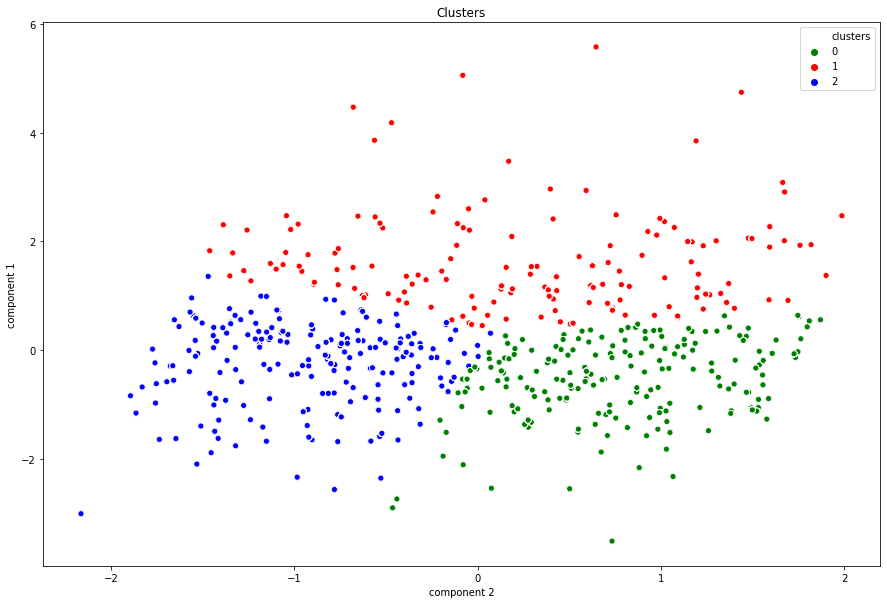

In [261]:
#Plot K-Means Clusters
plt.figure(figsize=(15, 10))
x_axis = X_kmeans['component 2']
y_axis = X_kmeans['component 1']
sns.scatterplot(x_axis, y_axis, hue= X_kmeans['clusters'],palette = ['g','r','b'])
plt.title('Clusters')
plt.show()

In [262]:
# From the 3 clusters derived from K-Means clustering and also our RFM Score, we would go ahead and create customer profiles.

In [263]:
#Assign X_kmeans DataFrame to new segmentation DataFrame
segmentation = X_kmeans.copy() 

In [264]:
#Create Customer Profiles and Add to DataFrame
def profile(df):
    if ((df['RFM_Score'] >= 3) & (df['RFM_Score'] <= 4)):
        return 'High Value'
    elif ((df['RFM_Score'] >= 5) & (df['RFM_Score'] <= 7)):
        return 'High-Mid Value'
    elif (df['RFM_Score'] == 8):
        return 'Mid Value'
    elif ((df['RFM_Score'] >= 9) & (df['RFM_Score'] <= 10)):
        return 'Mid-Low Value'
    elif ((df['RFM_Score'] >= 11) & (df['RFM_Score'] <= 12)):
        return 'Low Value'
    else:
        return 'No Segment'

In [265]:
#Apply profile function to segmentation DataFrame
segmentation['customer_profile']= segmentation.apply(profile, axis=1)

In [266]:
#Drop Redundant Fields
segmentation = segmentation.drop(['component 1','component 2'], axis=1)

In [267]:
#Drop duplicates
segmentation.drop_duplicates(inplace = True) 

In [268]:
#Display final DataFrame
segmentation.head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,clusters,RFM_Score,customer_profile
0,1.0,Laraine,Medendorp,Female,93.0,1953-10-12,Executive Secretary,Health,Mass Customer,N,Yes,11.0,0,7,High-Mid Value
121,2.0,Eli,Bockman,Male,81.0,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,Yes,16.0,0,10,Mid-Low Value
130,4.0,Talbot,NaN,Male,33.0,1961-10-03,NaN,IT,Mass Customer,N,No,7.0,0,11,Low Value
134,5.0,Sheila-kathryn,Calton,Female,56.0,1977-05-13,Senior Editor,NaN,Affluent Customer,N,Yes,8.0,0,9,Mid-Low Value
170,6.0,Curr,Duckhouse,Male,35.0,1966-09-16,NaN,Retail,High Net Worth,N,Yes,13.0,0,9,Mid-Low Value


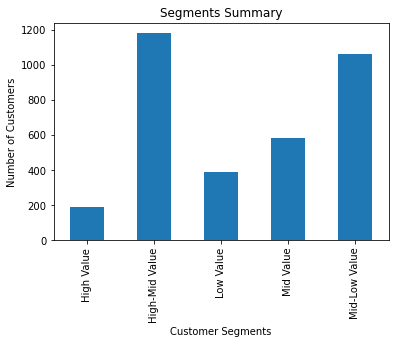

In [269]:
#Plot Bar Chart of Customers by Customer Profile
segmentation.groupby('customer_profile')['customer_profile'].count().plot.bar()
plt.xlabel("Customer Segments")
plt.ylabel("Number of Customers")
plt.title("Segments Summary");

In [270]:
#Export Segmentation DataFrame to csv
#segmentation.to_csv(r'C:\Users\hp\Desktop\KPMG Virtual Internship\SegmentationData.csv',index=False,header=True)

### Predict Segment of New Customers

In [271]:
pd.set_option('display.max_rows', None)
ncl = pd.read_excel('Sprocket.xlsx', sheet_name=2,skiprows=0)

In [272]:
ncl.head()

,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,address,postcode,state,country,property_valuation,Rank,Value
0,Chickie,Brister,Male,86,1957-07-12,General Manager,Manufacturing,Mass Customer,N,Yes,14,45 Shopko Center,4500,QLD,Australia,6,1,1.718750
1,Morly,Genery,Male,69,1970-03-22,Structural Engineer,Property,Mass Customer,N,No,16,14 Mccormick Park,2113,NSW,Australia,11,1,1.718750
2,Ardelis,Forrester,Female,10,1974-08-28,Senior Cost Accountant,Financial Services,Affluent Customer,N,No,10,5 Colorado Crossing,3505,VIC,Australia,5,1,1.718750
3,Lucine,Stutt,Female,64,1979-01-28,Account Representative III,Manufacturing,Affluent Customer,N,Yes,5,207 Annamark Plaza,4814,QLD,Australia,1,4,1.703125
4,Melinda,Hadlee,Female,34,1965-09-21,Financial Analyst,Financial Services,Affluent Customer,N,No,19,115 Montana Place,2093,NSW,Australia,9,4,1.703125


### An Overview of the Test Data

In [273]:
ncl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   first_name                           1000 non-null   object        
 1   last_name                            971 non-null    object        
 2   gender                               1000 non-null   object        
 3   past_3_years_bike_related_purchases  1000 non-null   int64         
 4   DOB                                  983 non-null    datetime64[ns]
 5   job_title                            894 non-null    object        
 6   job_industry_category                835 non-null    object        
 7   wealth_segment                       1000 non-null   object        
 8   deceased_indicator                   1000 non-null   object        
 9   owns_car                             1000 non-null   object        
 10  tenure       

In [274]:
ncl.describe()

,past_3_years_bike_related_purchases,tenure,postcode,property_valuation,Rank,Value
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,49.836000,11.388000,3019.227000,7.397000,498.819000,0.881714
std,27.796686,5.037145,848.895767,2.758804,288.810997,0.293525
min,0.000000,0.000000,2000.000000,1.000000,1.000000,0.340000
25%,26.750000,7.000000,2209.000000,6.000000,250.000000,0.649531
50%,51.000000,11.000000,2800.000000,8.000000,500.000000,0.860000
75%,72.000000,15.000000,3845.500000,9.000000,750.250000,1.075000
max,99.000000,22.000000,4879.000000,12.000000,1000.000000,1.718750


In [275]:
ncl.describe(include=object)

,first_name,last_name,gender,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,address,state,country
count,1000,971,1000,894,835,1000,1000,1000,1000,1000,1000
unique,940,961,3,184,9,3,1,2,1000,3,1
top,Dorian,Crellim,Female,Associate Professor,Financial Services,Mass Customer,N,No,902 Westend Lane,NSW,Australia
freq,3,2,513,15,203,508,1000,507,1,506,1000


In [276]:
#Missing Values
total = ncl.isnull().sum().sort_values(ascending=False)
pc1 = ncl.isnull().sum()/ncl.isnull().count()*100
pc2 = (round(pc1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, pc2], axis=1, keys=['Total', '%'])
missing_data.head()


,Total,%
job_industry_category,165,16.5
job_title,106,10.6
last_name,29,2.9
DOB,17,1.7
Value,0,0.0


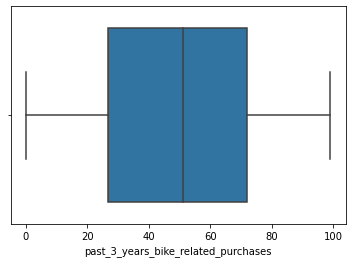

In [277]:
#past_3_years_bike_related_purchases outlier detection
sns.boxplot(x=ncl['past_3_years_bike_related_purchases'])

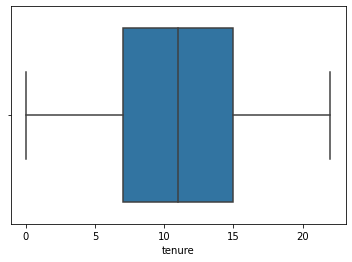

In [278]:
#tenure outlier detection
sns.boxplot(x=ncl['tenure'])

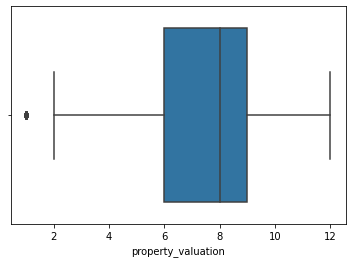

In [279]:
#property_valuation outlier detection
sns.boxplot(x=ncl['property_valuation'])

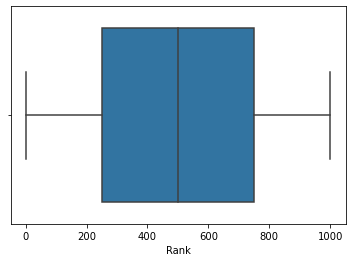

In [280]:
#Rank outlier detection
sns.boxplot(x=ncl['Rank'])

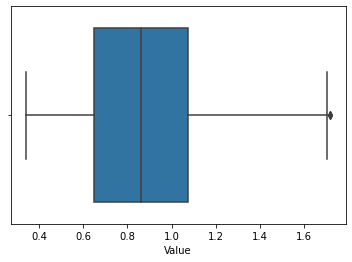

In [281]:
#Value outlier detection
sns.boxplot(x=ncl['Value'])

### Summary of data review

#### Dataset
1. There are 1000 records in the dataset with 18 columns

#### Missing Values
The following columns have missing values in them
1. job_industry_category(165 records missing) - 16.5% of data in the column
2. job_title(106 records missing) - 10.6% of data in the column
3. last_name(29 records missing)- 2.9% of data in the column
4. DOB(17 records missing)- 1.7% of data in the column

Solution:
1. job_industry_category - Use fillna() function to fill missing values
2. job_title and last_name - These columns will be dropped as they serve no purpose to our analysis
3. DOB- An age column will be feature engineered from this column and missing values will be filled using K-Nearest Neighbour
   Algorithm.
   
#### Outliers
The following columns have some outlier datapoints that have a potential to negatively affect our analysis
1. Property Valuation
2. Value

Treatment:
1. These outliers will be dropped from the dataset

#### Categorical Variables
The categorical variables in our dataset will be converted to numerical variables using LabelEncoder to allow for machine learning analysis

### Feature Engineering

In [282]:
#Feature engineer age column

def from_dob_to_age(born):
    today = dt.date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

ncl['age']= ncl['DOB'].apply(lambda x: from_dob_to_age(x))

In [283]:
#Drop Redundant Fields
ncl = ncl.drop(['first_name','last_name','DOB','job_title','deceased_indicator','postcode','address'], axis=1)

### Convert Categorical Variables to Numerical

In [284]:
#Fill job_industry_category missing values
ncl['job_industry_category'] = ncl['job_industry_category'].fillna('Not Given')

In [285]:
#Convert Categorical Variables to Numerical
label = LabelEncoder()
ncl['sex'] = label.fit_transform(ncl['gender'])
ncl['class'] = label.fit_transform(ncl['wealth_segment'])
ncl['car_owner'] = label.fit_transform(ncl['owns_car'])
ncl['industry'] = label.fit_transform(ncl['job_industry_category'])

In [286]:
#Drop Redundant Fields
ncl = ncl.drop(['gender','wealth_segment','owns_car','job_industry_category','country','state','Rank',
                'property_valuation','Value'], axis=1)

In [287]:
ncl.head()

,past_3_years_bike_related_purchases,tenure,age,sex,class,car_owner,industry
0,86,14,63.0,1,2,1,5
1,69,16,50.0,1,2,0,7
2,10,10,46.0,0,0,0,2
3,64,5,41.0,0,0,1,5
4,34,19,55.0,0,0,0,2


### Missing Values

In [288]:
#Fill Missing Values Using K-Nearest Neighbour Algorithm
imputer = KNNImputer(n_neighbors=2)
ncl = pd.DataFrame(imputer.fit_transform(ncl),columns = ncl.columns)

### Convert columns to int data type

In [289]:
ncl['past_3_years_bike_related_purchases']= ncl['past_3_years_bike_related_purchases'].astype('int64')
ncl['industry']= ncl['industry'].astype('int64')
ncl['sex']= ncl['sex'].astype('int64')
ncl['class']= ncl['class'].astype('int64')
ncl['car_owner']= ncl['car_owner'].astype('int64')
ncl['tenure']= ncl['tenure'].astype('int64')
ncl['age']= ncl['age'].astype('int64')

In [290]:
ncl.head()

,past_3_years_bike_related_purchases,tenure,age,sex,class,car_owner,industry
0,86,14,63,1,2,1,5
1,69,16,50,1,2,0,7
2,10,10,46,0,0,0,2
3,64,5,41,0,0,1,5
4,34,19,55,0,0,0,2


### An Overview of the Train Data

In [291]:
train = segmentation.copy()
train.head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,clusters,RFM_Score,customer_profile
0,1.0,Laraine,Medendorp,Female,93.0,1953-10-12,Executive Secretary,Health,Mass Customer,N,Yes,11.0,0,7,High-Mid Value
121,2.0,Eli,Bockman,Male,81.0,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,Yes,16.0,0,10,Mid-Low Value
130,4.0,Talbot,NaN,Male,33.0,1961-10-03,NaN,IT,Mass Customer,N,No,7.0,0,11,Low Value
134,5.0,Sheila-kathryn,Calton,Female,56.0,1977-05-13,Senior Editor,NaN,Affluent Customer,N,Yes,8.0,0,9,Mid-Low Value
170,6.0,Curr,Duckhouse,Male,35.0,1966-09-16,NaN,Retail,High Net Worth,N,Yes,13.0,0,9,Mid-Low Value


In [292]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3410 entries, 0 to 127540
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   customer_id                          3410 non-null   float64       
 1   first_name                           3410 non-null   object        
 2   last_name                            3301 non-null   object        
 3   gender                               3410 non-null   object        
 4   past_3_years_bike_related_purchases  3410 non-null   float64       
 5   DOB                                  3410 non-null   datetime64[ns]
 6   job_title                            2995 non-null   object        
 7   job_industry_category                2850 non-null   object        
 8   wealth_segment                       3410 non-null   object        
 9   deceased_indicator                   3410 non-null   object        
 10  owns_car  

In [293]:
#Missing Values
total = train.isnull().sum().sort_values(ascending=False)
pc1 = train.isnull().sum()/train.isnull().count()*100
pc2 = (round(pc1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, pc2], axis=1, keys=['Total', '%'])
missing_data.head()

,Total,%
job_industry_category,560,16.4
job_title,415,12.2
last_name,109,3.2
customer_profile,0,0.0
RFM_Score,0,0.0


### Feature Engineering

In [294]:
#Feature engineer age column

def from_dob_to_age(born):
    today = dt.date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

train['age']= train['DOB'].apply(lambda x: from_dob_to_age(x))

In [295]:
#Drop Redundant Fields
train = train.drop(['first_name','last_name','DOB','job_title','deceased_indicator'], axis=1)

### Outlier Detection

In [296]:
# identify outliers with standard deviation
train2 = train[['past_3_years_bike_related_purchases','tenure','clusters', 'RFM_Score','age']]
upper = train2.mean() + 2*train2.std() #Upper limit
lower = train2.mean() - 2*train2.std() #Lower Limit
train2[(train2 > upper) | (train2 < lower)] #Identify Outliers
train3=train2[(train2 < upper) & (train2 > lower)] #Filter out Outliers

In [297]:
#Add columns back to DataFrame
train = pd.concat([train,train3], axis= 1)
train.columns.values[-5: ] = ['bike_related_purchases', 'Tenure','Clusters','RFM_score','Age']

In [298]:
#Drop Redundant Fields
train = train.drop(['past_3_years_bike_related_purchases','tenure','clusters', 'RFM_Score','age','customer_id'], axis=1)

### Convert Categorical Variables to Numerical

In [299]:
#Fill job_industry_category missing values
train['job_industry_category'] = train['job_industry_category'].fillna('Not Given')

In [300]:
#Convert Categorical Variables to Numerical
label = LabelEncoder()
train['sex'] = label.fit_transform(train['gender'])
train['class'] = label.fit_transform(train['wealth_segment'])
train['car_owner'] = label.fit_transform(train['owns_car'])
train['industry'] = label.fit_transform(train['job_industry_category'])

In [301]:
#Drop Redundant Fields
train = train.drop(['gender','wealth_segment','owns_car','job_industry_category','customer_profile'], axis=1)

### Missing Values

In [302]:
#Fill Missing Values Using K-Nearest Neighbour Algorithm
imputer = KNNImputer(n_neighbors=2)
train = pd.DataFrame(imputer.fit_transform(train),columns = train.columns)

### Convert Columns to int datatype

In [303]:
train['bike_related_purchases']= train['bike_related_purchases'].astype('int64')
train['industry']= train['industry'].astype('int64')
train['sex']= train['sex'].astype('int64')
train['class']= train['class'].astype('int64')
train['car_owner']= train['car_owner'].astype('int64')
train['Tenure']= train['Tenure'].astype('int64')
train['Age']= train['Age'].astype('int64')
train['Clusters']= train['Clusters'].astype('int64')
train['RFM_score']= train['RFM_score'].astype('int64')

In [304]:
train.head()

,bike_related_purchases,Tenure,Clusters,RFM_score,Age,sex,class,car_owner,industry
0,93,11,0,7,67,0,2,1,3
1,81,16,0,10,39,1,2,1,2
2,33,7,0,11,59,1,2,0,4
3,56,8,0,9,43,0,0,1,6
4,35,13,0,9,54,1,1,1,8


### Scale Features

In [305]:
#Define StandardScaler
scaler = StandardScaler()

#Transform ncl Variables
scaled_features = scaler.fit_transform(ncl)
N = pd.DataFrame(scaler.fit_transform(ncl), columns=ncl.columns)
N.head()

,past_3_years_bike_related_purchases,tenure,age,sex,class,car_owner,industry
0,1.301669,0.518807,0.826829,0.930754,0.890393,1.014099,0.278604
1,0.689780,0.916056,0.064234,0.930754,0.890393,-0.986097,1.184632
2,-1.433838,-0.275691,-0.170411,-0.945766,-1.539056,-0.986097,-1.080439
3,0.509812,-1.268813,-0.463717,-0.945766,-1.539056,1.014099,0.278604
4,-0.569993,1.511930,0.357540,-0.945766,-1.539056,-0.986097,-1.080439


In [306]:
train_to_scale = train[['bike_related_purchases','Tenure','Age','RFM_score','sex','car_owner','industry','class']]

#Transform train Variables
scaled_features = scaler.fit_transform(train_to_scale)
T = pd.DataFrame(scaler.fit_transform(train_to_scale), columns=train_to_scale.columns)
T.head()

,bike_related_purchases,Tenure,Age,RFM_score,sex,car_owner,industry,class
0,1.536807,0.056144,1.955404,-0.532715,-0.969953,0.989498,-0.632841,0.905302
1,1.118016,0.937591,-0.285244,0.973137,1.030978,0.989498,-1.083266,0.905302
2,-0.557150,-0.649014,1.315219,1.475087,1.030978,-1.010614,-0.182416,0.905302
3,0.245533,-0.472724,0.034849,0.471186,-0.969953,0.989498,0.718435,-1.520693
4,-0.487352,0.408722,0.915103,0.471186,1.030978,0.989498,1.619286,-0.307696


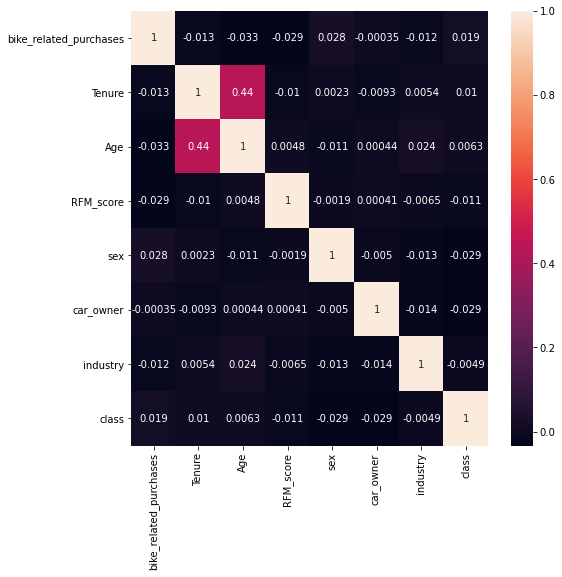

In [307]:
#How correlated are the features?
plt.figure(figsize=(8,8))
sns.heatmap(T.corr(),annot=True)

### Split data into Dependent and Independent Variables

In [308]:
# Dependent and Independent variables
P = T[['bike_related_purchases', 'Tenure', 
       'Age', 'RFM_score', 'sex','car_owner', 'industry', 'class']] #Returns all columns in the dataset except cluster
y = train['Clusters'] #Returns just the cluster column

### Balancing Dataset by Oversampling(SMOTE Algorithm)

In [309]:
#P and y Oversampling
print("Before OverSampling, counts of label '2': {}".format(sum(y == 2)))
print("Before OverSampling, counts of label '1': {}".format(sum(y == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(y == 0))) 
  
# import SMOTE module from imblearn library 
from imblearn.over_sampling import SMOTE 
sm = SMOTE() 
P_train_res, y_train_res = sm.fit_resample(P,y) 
  
print('After OverSampling, the shape of P: {}'.format(P_train_res.shape)) 
print('After OverSampling, the shape of y: {} \n'.format(y_train_res.shape)) 
  
print("After OverSampling, counts of label '2': {}".format(sum(y_train_res == 2)))
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0))) 

Before OverSampling, counts of label '2': 1316
Before OverSampling, counts of label '1': 704
Before OverSampling, counts of label '0': 1390 

After OverSampling, the shape of P: (4170, 8)
After OverSampling, the shape of y: (4170,) 

After OverSampling, counts of label '2': 1390
After OverSampling, counts of label '1': 1390
After OverSampling, counts of label '0': 1390


### Dimensionality Reduction using Principal Component Analysis (PCA)


Text(0, 0.5, 'Cumulative Explained Variance')

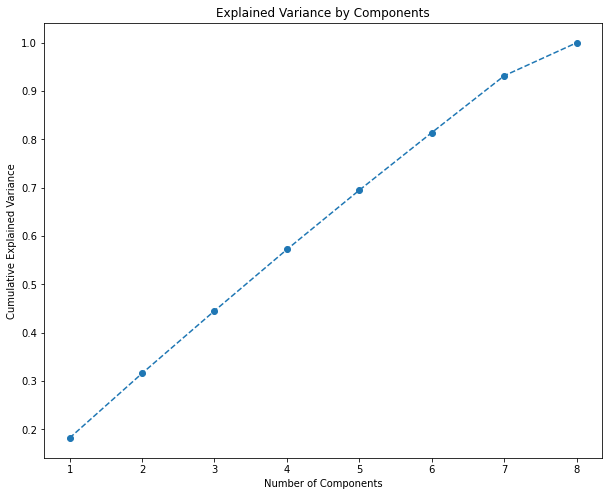

In [310]:
#PCA on Train data 

#Instantiate PCA Model
pca = PCA()

#Fit Training Model
pca.fit(P_train_res)

#The attribute shows how much variance each of the three individual components has.
pca.explained_variance_ratio_

plt.figure(figsize = (10,8))
plt.plot(range(1,9),pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

In [311]:
#The graph shows the amount of variance captured (y-axis) depending on the number of components we include(x-axis). 
# We will preserve around 80% of the variance. So in this instance, we will keep 6 components

#Select 2 components for the pca model
pca = PCA(n_components=6)

#Fit the model with selected components
pca.fit(P_train_res)

#Transform model
pca.transform(P_train_res)

train_scores_pca = pca.transform(P_train_res)

Text(0, 0.5, 'Cumulative Explained Variance')

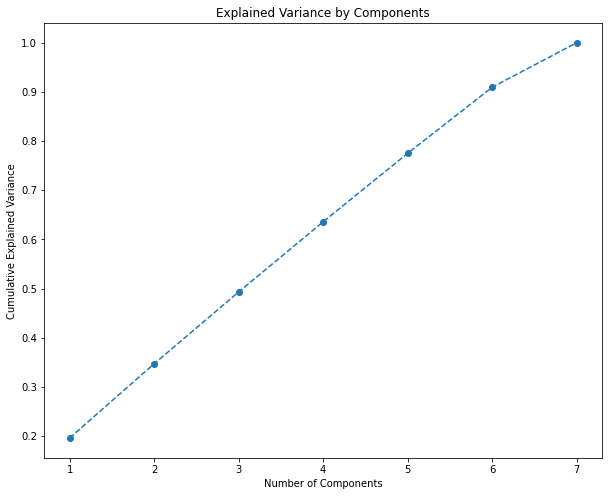

In [312]:
#PCA on Test data 

#Instantiate PCA Model
pca = PCA()

#Fit Training Model
pca.fit(N)

#The attribute shows how much variance each of the three individual components has.
pca.explained_variance_ratio_

plt.figure(figsize = (10,8))
plt.plot(range(1,8),pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

In [313]:
#The graph shows the amount of variance captured (y-axis) depending on the number of components we include(x-axis). 
# We will preserve around 80% of the variance. So in this instance, we will keep 6 components

#Select 2 components for the pca model
pca = PCA(n_components=6)

#Fit the model with selected components
pca.fit(N)

#Transform model
pca.transform(N)

ncl_scores_pca = pca.transform(N)

### Train final model with the dataset

In [314]:
#Instantiate model
classifier = DecisionTreeClassifier()

#Instantiate the OneVsRest Model
ovr = OneVsRestClassifier(classifier)

In [315]:
# fit model
ovr.fit(train_scores_pca, y_train_res)

OneVsRestClassifier(estimator=DecisionTreeClassifier())

### Make prediction with model

In [316]:
# make prediction on training dataset
test = ovr.predict(ncl_scores_pca)

#Show the inputs and predicted outputs
for i in range(len(ncl_scores_pca)):
    print('P=%s, Predicted=%s' % (ncl_scores_pca[i], test[i]))

P=[-0.69471956  0.44251515  0.96785893 -0.59943908  1.24979798  1.36585457], Predicted=0
P=[-0.33618782  0.02861385 -1.12050497 -0.92559027  1.42176823  0.61173596], Predicted=2
P=[ 0.0485877   0.28813555 -0.8425949   0.80453323 -1.76491885 -1.63567944], Predicted=0
P=[ 1.05173952 -0.07033433  1.06101076  1.71610763  0.33430485 -0.8091429 ], Predicted=2
P=[-1.44877057  0.9715656  -0.64638037  0.57872372 -1.01188054 -1.79137587], Predicted=1
P=[-2.59856346  0.57634052  1.1850556   0.25068827 -1.18101584 -0.46396161], Predicted=2
P=[ 0.73587118  0.21905654 -0.83562598 -1.36242257 -1.34283623  0.46223196], Predicted=2
P=[ 0.14017198 -1.62327028  0.97112053  0.24891781  1.56559383  0.2454268 ], Predicted=2
P=[ 0.99743621 -0.41899852  0.60249124 -0.2437226   0.1194755   1.55896611], Predicted=0
P=[-0.04695856  0.52888648  0.93717624 -0.52594173  0.33561349  1.10824585], Predicted=1
P=[ 2.59813414  0.21687736 -0.81368464  0.02926926  2.10548075 -0.02583992], Predicted=2
P=[ 1.53679014 -0.090

P=[-0.64339402  0.64043797 -0.69493531 -1.26018644  1.6682033   0.33616834], Predicted=0
P=[ 1.87507479  0.45562659  0.00931697  0.65628409  1.09041388 -2.04728686], Predicted=2
P=[-0.8246756   0.14919781  0.4094402  -0.38159837 -0.9742696   1.50548398], Predicted=2
P=[-0.23199709 -1.05616715  1.0144954  -0.19172581 -1.89010273  0.05754585], Predicted=0
P=[ 1.30674203 -1.8636318   1.05765788  0.21392382  0.81502042  0.23322546], Predicted=2
P=[-0.5061828   1.78889635  0.68872694  1.26400589  1.31157867  0.41680092], Predicted=2
P=[ 0.70264361  1.05627331 -0.06742591  1.75106141 -1.68742229  0.50486331], Predicted=2
P=[-2.01457616 -0.79904432 -0.53819089  0.40335098  0.65330647  2.13079012], Predicted=0
P=[-0.6633421   0.69489995  0.0670566   0.61930156 -1.94628375  1.08114269], Predicted=2
P=[ 0.82694619 -1.84621407 -0.99751896 -0.49143275 -1.10846365 -0.5207972 ], Predicted=0
P=[-1.51876172 -0.27293748 -0.16268346 -1.41551416 -0.71131171 -0.87644217], Predicted=2
P=[-1.01395794 -0.329

P=[ 0.62467918 -0.03590871  0.66075785 -1.71763966  0.19201793 -1.33761171], Predicted=2
P=[-0.88361742  1.44049884  0.3541858   1.39722102  0.84324067  0.71762201], Predicted=2
P=[ 0.52928096  0.47713895  0.40152428 -0.67378471  0.67096046 -1.69558943], Predicted=2
P=[2.68171859 0.45585943 1.06323214 0.48026924 0.7898247  0.70985707], Predicted=2
P=[ 0.55081843  1.01396096  1.72209533 -1.31145211 -0.69362314  1.01439712], Predicted=2
P=[ 1.40728188 -0.6363121   0.48908899 -1.35709452  1.48021137 -1.17306487], Predicted=2
P=[ 0.34979206 -0.14883037 -0.9713647  -1.15963891  0.37678062  0.75703128], Predicted=2
P=[ 0.22461681  1.09774582 -1.59764596  0.92771641 -0.15812779 -0.17623992], Predicted=1
P=[ 0.37296949  0.16281771  1.22640224  1.6089739   1.44773778 -0.8041061 ], Predicted=2
P=[ 0.06006405 -1.18030699 -0.9067642   0.42960398  2.07030464 -0.78408578], Predicted=2
P=[ 0.63706016  1.26379131  0.55725359  1.25284913 -0.39195874  0.63802534], Predicted=0
P=[-0.69520342 -0.18426684 

P=[ 1.74450781 -0.89983256  0.02361149 -1.2189758  -1.30969246 -1.11220504], Predicted=2
P=[-0.95251818 -0.82210505 -0.19756408 -1.02885794  2.10149604 -0.71688392], Predicted=2
P=[ 0.33676867  1.55295647  2.07169781 -1.50146864 -0.03651667  0.70184871], Predicted=2
P=[ 0.83793142 -1.07610973 -2.00994317 -0.26490459 -0.56402177  0.9385752 ], Predicted=2
P=[ 0.9298262   1.17123643 -1.30048378  1.05410825  1.94993201 -0.4432856 ], Predicted=2
P=[-1.8833649   0.43004026  0.61581735 -0.49005416  0.93530787  1.55278695], Predicted=2
P=[-2.60996527 -0.67907788  0.82365338 -0.30907301 -1.54689244  0.28338639], Predicted=2
P=[-0.81782006 -0.57383593  1.5147064  -0.25654714  1.5807906  -0.18244046], Predicted=2
P=[-0.38656852 -0.29538771 -0.58828251 -0.0081823   0.29956316 -1.22476174], Predicted=2
P=[-1.2712983  -0.76408271 -0.41222961  2.59546617 -0.58142505 -0.24969183], Predicted=2
P=[-0.78241167 -0.05867829 -0.93230028  0.9835388   0.7937815  -1.24853853], Predicted=1
P=[ 1.06740591  0.299

P=[ 0.41528615  0.42461626  1.52042819  1.3488575   1.39474822 -0.89002182], Predicted=2
P=[ 1.78654701  0.79628414  0.29129808  1.7094287  -0.06589586  0.54790415], Predicted=2
P=[ 0.3690168  -0.85892079  0.12949321  2.28117131 -0.57704653 -0.31674824], Predicted=2
P=[ 0.07121341 -0.29642692 -1.28396581 -0.9734555  -0.14383171  0.83022385], Predicted=2
P=[-1.34812052  0.59066858 -0.42208351  1.92871525  0.78790321  1.24511687], Predicted=2
P=[-0.88019202 -0.73511091 -1.87027257 -0.65619866 -0.32810912  1.22137311], Predicted=2
P=[1.26843546e-01 2.38076827e-01 1.07437649e-03 1.01215335e+00
 1.04619445e-01 1.10489270e+00], Predicted=2
P=[-1.29343373 -0.04126987  1.85286392 -0.73110752  0.55782602 -0.28132934], Predicted=1
P=[-0.52469919 -1.13700933  0.8538142  -0.12186923 -2.10144508  0.14559502], Predicted=0
P=[ 1.38889056 -0.14068923 -0.87045085 -0.82552314  1.96329474  0.35351426], Predicted=2
P=[-1.09847234  1.34129801  1.5843028  -1.20313116  0.68099953  1.01035565], Predicted=1
P=

P=[ 0.28047726  0.72794694  1.28619675 -0.88822136 -0.26874347  1.07507779], Predicted=2
P=[ 1.61885611  1.03459451  1.80705061 -1.03850883  0.25980333  0.62529809], Predicted=2
P=[-1.77974751  0.06825596  0.54649042  1.90730362  1.39460799 -0.45750395], Predicted=2
P=[ 1.44748357  1.39405899  0.30913607 -2.00124222 -0.1071114  -0.32914197], Predicted=2
P=[ 0.98755643  0.34238301 -1.89688573  1.35322982  0.91295343  0.08845632], Predicted=2
P=[ 0.92248354  0.0046582   0.73785566 -1.72492061  0.23529631 -1.42932895], Predicted=2
P=[ 0.07308559 -0.87391385  1.45746167 -0.56103544 -1.69555661  0.05361362], Predicted=2
P=[-0.9229271   1.52412628  1.59559897 -1.13333373  0.58353768  0.77263747], Predicted=2
P=[-0.12261944 -1.07080781 -1.91977545  1.83810204 -0.07382905 -1.00353438], Predicted=2
P=[-1.95467745 -0.7321517  -0.45965518  0.36323138  0.77843148  2.08438278], Predicted=1
P=[-0.33219577  1.38853744 -0.62290454  0.59540948 -0.80498216  2.69348068], Predicted=2
P=[-1.27800898 -0.450

P=[ 0.65172304  1.26752529 -1.63725314  0.9128295  -1.62130476 -0.41410649], Predicted=0
P=[-0.22662075 -1.79022927  0.83248684  0.26341344  1.45557404  0.45728702], Predicted=1
P=[-0.87676093 -0.76815327 -0.52388168 -0.88321497  0.1897522  -0.87898871], Predicted=1
P=[-0.18464527 -0.20978207 -1.46908623  1.42448512 -1.11045727 -1.51054555], Predicted=0
P=[ 0.44978888  0.69755419  0.03468822  1.68724544 -0.09491842  0.91991151], Predicted=2
P=[-0.56577247 -1.34062266  0.21607114  1.31155882 -0.47394541  0.18457517], Predicted=2
P=[-2.21792086  0.73999083 -0.84743387 -1.35690095  1.8866722   0.62839137], Predicted=0
P=[ 0.8834799   0.50673017  0.28513438 -0.67263254 -0.88581587 -1.80579256], Predicted=2
P=[-0.27402535 -1.06781469  0.34533564  1.23913969 -0.97418663 -0.07522843], Predicted=2
P=[-0.17719901  0.40364449 -0.08446997 -0.38559317 -0.08738639 -1.66163965], Predicted=2
P=[ 1.88418483 -1.35077558 -0.76129971  0.55353025  1.76774056 -1.08163297], Predicted=1
P=[-1.17319577  0.382

In [317]:
#Append prediction to New Customer List DataFrame
newcust['Predicted_Clusters'] = test

In [318]:
#Export newcust DataFrame to csv
#newcust.to_csv(r'C:\Users\hp\Desktop\KPMG Virtual Internship\NewCustomerData.csv',index=False,header=True)